# VK MADE] Optical Character Recognition
## OCR task

#### План:
1. Общая схема
2. Подготовка данных
3. Построение модели `CRNN` (`Convolutional Recurrent Neural Network`)
4. Интерфейс и применение функции потерь `CTC Loss` (`Connectionist Temporal Classification`)
5. Обучение и результаты
6. Анализ проблем и что делать дальше

In [1]:
import os
import cv2
import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

from sklearn.model_selection import train_test_split

import torch
from torch.utils.data import DataLoader,Dataset
from torch.nn import Module, Sequential, Conv2d, AvgPool2d, GRU, Linear
from torch.nn.functional import ctc_loss, log_softmax
from torchvision import datasets, models, transforms
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torchvision import transforms, models
import random

from string import digits, ascii_uppercase

import warnings
warnings.simplefilter('ignore')

# будем отображать графики прямо в jupyter'e
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
#графики в svg выглядят более четкими
# %config InlineBackend.figure_format = 'svg' 
plt.rcParams['font.family'] = 'DejaVu Serif'
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 8
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['axes.titlesize'] = 15
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['figure.figsize'] = [7, 5]
from IPython.display import clear_output

In [2]:
SEED = 42

def seed_everything(seed):
    """
    Fixing random seed for all libraries.
    """

    import os

    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

seed_everything(SEED)

## Данные

In [3]:
TRAIN_DATA_PATH = "/kaggle/input/vk-made-ocr/train/train/"
TEST_DATA_PATH = "/kaggle/input/vk-made-ocr/test/test/"
TRAIN_LABELS_PATH = "/kaggle/input/vk-made-ocr/train_labels.csv"

train_labels = pd.read_csv(TRAIN_LABELS_PATH)
train_labels.head()

,Id,Expected
0,1.jpg,Атырау
1,2.jpg,транз
2,3.jpg,ходят
3,4.jpg,"ощущений,"
4,5.jpg,74


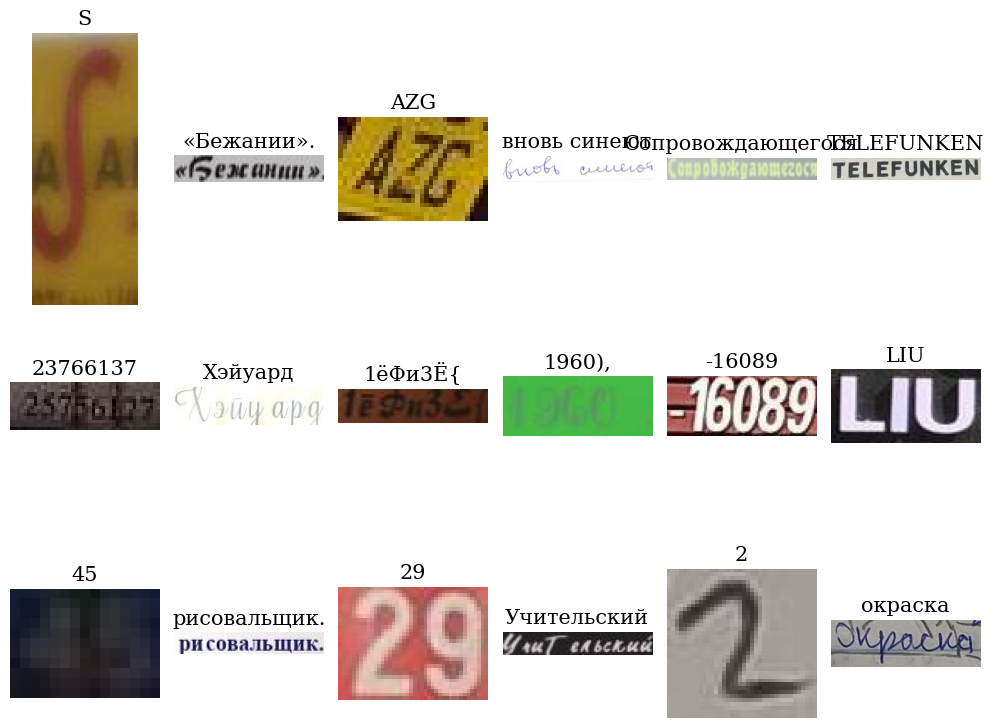

In [8]:
sample = train_labels.sample(n=18)

fig, axs = plt.subplots(3, 6, figsize=(10, 8))

for i, ax in enumerate(axs.flatten()):
    img_name = sample.iloc[i]["Id"]
    img = Image.open(TRAIN_DATA_PATH + img_name)
    
    label = sample.iloc[i]["Expected"]
    
    # отобразить изображение
    ax.imshow(img)
    ax.set_title(label)
    ax.axis('off')

plt.tight_layout()
plt.show()

## Убираем Nan и длинные предложения

In [10]:
train_labels = train_labels.dropna()
train_labels = train_labels[train_labels["Expected"]!="None"]
train_labels.shape

(275874, 2)

In [12]:
train_labels["Expected_Length"] = train_labels["Expected"].apply(len)
train_labels.head()

,Id,Expected,Expected_Length
0,1.jpg,Атырау,6
1,2.jpg,транз,5
2,3.jpg,ходят,5
3,4.jpg,"ощущений,",9
4,5.jpg,74,2


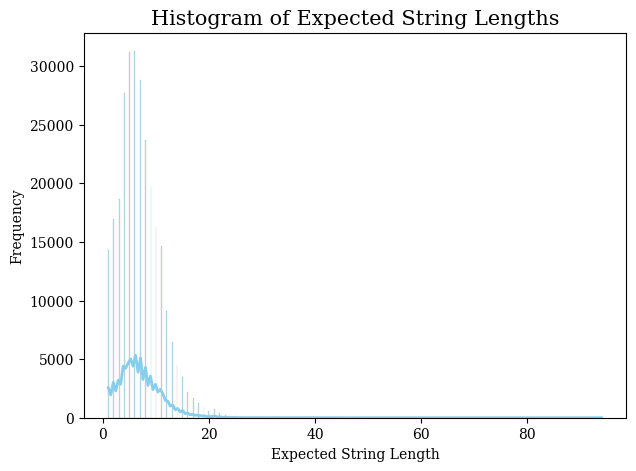

In [15]:
sns.histplot(train_labels['Expected_Length'], bins='auto', color='skyblue', kde=True)

plt.title('Histogram of Expected String Lengths')
plt.xlabel('Expected String Length')
plt.ylabel('Frequency')

plt.show()

In [16]:
# train_labels = train_labels[(train_labels["Expected_Length"] >= 7) & (train_labels["Expected_Length"] <= 10)]
train_labels = train_labels[train_labels["Expected_Length"] <= 22]
train_labels

,Id,Expected,Expected_Length
0,1.jpg,Атырау,6
1,2.jpg,транз,5
2,3.jpg,ходят,5
3,4.jpg,"ощущений,",9
4,5.jpg,74,2
...,...,...,...
275995,275996.jpg,DO,2
275996,275997.jpg,BASUCC,6
275997,275998.jpg,"1,120",5
275998,275999.jpg,"наблюдателей,",13


In [18]:
train_labels["file"] = train_labels["Id"].apply(lambda x: TRAIN_DATA_PATH + x)
train_labels["text"] = train_labels["Expected"]
train_labels.head()

,Id,Expected,Expected_Length,file,text
0,1.jpg,Атырау,6,/kaggle/input/vk-made-ocr/train/train/1.jpg,Атырау
1,2.jpg,транз,5,/kaggle/input/vk-made-ocr/train/train/2.jpg,транз
2,3.jpg,ходят,5,/kaggle/input/vk-made-ocr/train/train/3.jpg,ходят
3,4.jpg,"ощущений,",9,/kaggle/input/vk-made-ocr/train/train/4.jpg,"ощущений,"
4,5.jpg,74,2,/kaggle/input/vk-made-ocr/train/train/5.jpg,74


In [19]:
config = train_labels[["file", "text"]].to_dict('records')
config[:5]

[{'file': '/kaggle/input/vk-made-ocr/train/train/1.jpg', 'text': 'Атырау'},
 {'file': '/kaggle/input/vk-made-ocr/train/train/2.jpg', 'text': 'транз'},
 {'file': '/kaggle/input/vk-made-ocr/train/train/3.jpg', 'text': 'ходят'},
 {'file': '/kaggle/input/vk-made-ocr/train/train/4.jpg', 'text': 'ощущений,'},
 {'file': '/kaggle/input/vk-made-ocr/train/train/5.jpg', 'text': '74'}]

In [20]:
len(train_labels), len(config)

(274531, 274531)

In [21]:
print("Total items in data:", len(config))
print("First 3 items:")
for item in config[:3]:
    print(item)

Total items in data: 274531
First 3 items:
{'file': '/kaggle/input/vk-made-ocr/train/train/1.jpg', 'text': 'Атырау'}
{'file': '/kaggle/input/vk-made-ocr/train/train/2.jpg', 'text': 'транз'}
{'file': '/kaggle/input/vk-made-ocr/train/train/3.jpg', 'text': 'ходят'}


Посмотрим на данные.

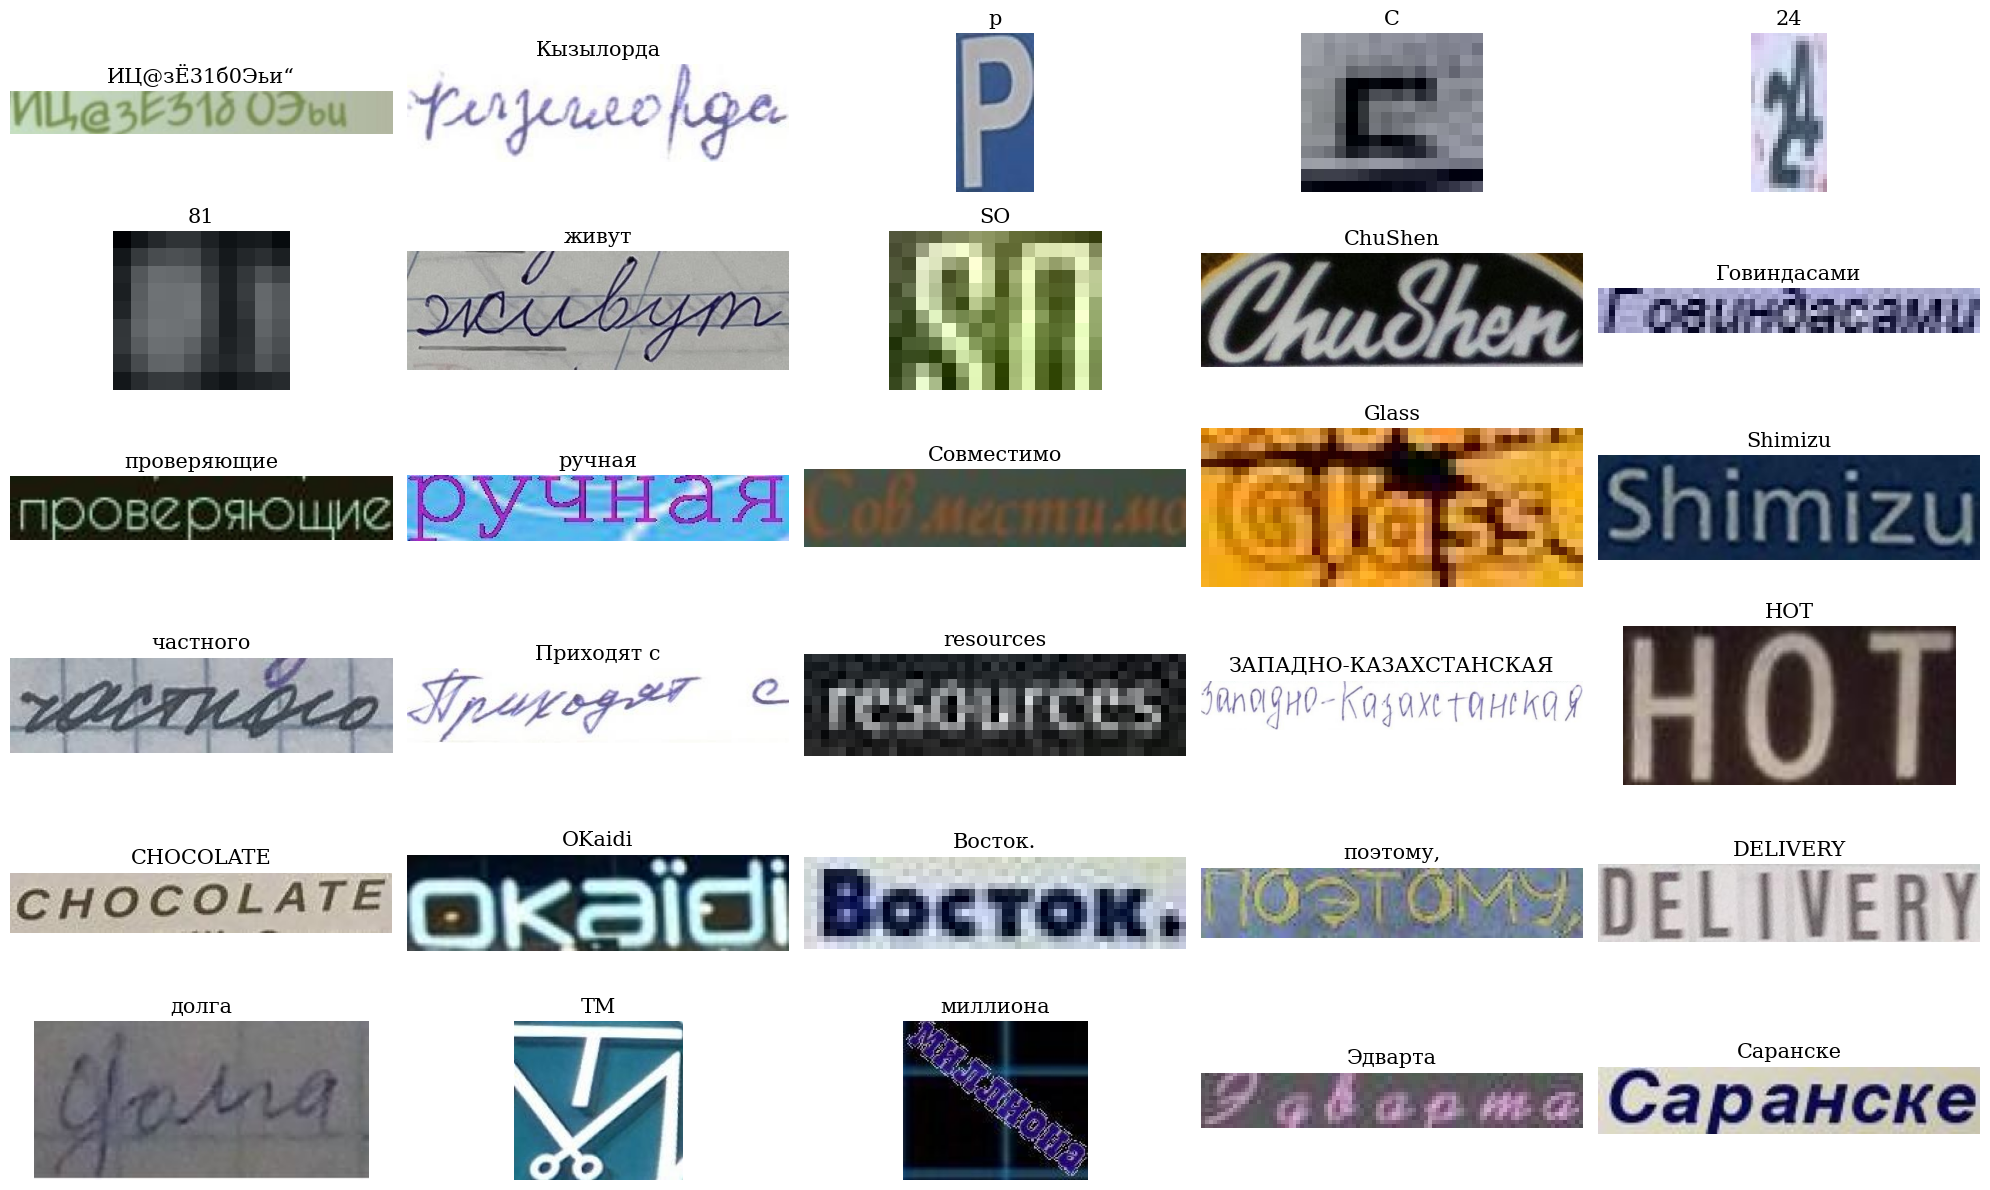

In [22]:
SAMPLE_SIZE = 30
NUM_COLS = 5
NUM_ROWS = SAMPLE_SIZE // NUM_COLS + int(SAMPLE_SIZE % NUM_COLS != 0)

random_idxs = np.random.choice(len(config), size=SAMPLE_SIZE, replace=False)
plt.figure(figsize=(20, 2 * NUM_ROWS))
for i, idx in enumerate(random_idxs, 1):
    item = config[idx]
    text = item["text"]
    image = cv2.imread(item["file"])
    
    plt.subplot(NUM_ROWS, NUM_COLS, i)
    plt.imshow(image[:, :, ::-1])
    plt.title(text)
    plt.axis("off")
    
plt.tight_layout()
plt.show()

### Поворот изображения

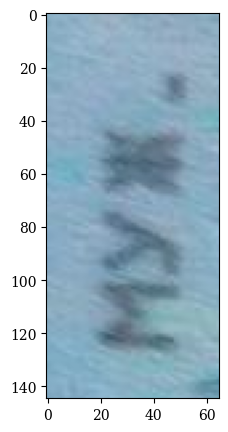

In [23]:
plt.imshow(Image.open(TRAIN_DATA_PATH + "2555.jpg"))

In [24]:
Image.open(TRAIN_DATA_PATH + "2555.jpg").size

(65, 145)

In [25]:
145/65

2.230769230769231

In [28]:
def rotate_if_need(img):
    h, w, c = img.shape
    rotated = False
    if h > w*1.75:
        img = cv2.rotate(img, cv2.ROTATE_90_COUNTERCLOCKWISE)
        rotated = True
    return img, rotated

def load_image(img_path):
    img = cv2.imread(img_path).astype(np.float32) / 255.
#     img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img, rotated = rotate_if_need(img)
    return img, rotated

In [29]:
img, rotated = load_image(TRAIN_DATA_PATH + "2555.jpg")
img.shape, rotated

((65, 145, 3), True)

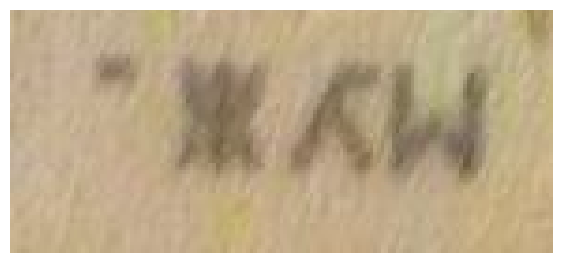

In [30]:
plt.imshow(img)
plt.axis('off')  
plt.show()

## Алфавит для декодирования

In [36]:
recordings = train_labels["Expected"].values

# Преобразуем массив в одну большую строку
all_symbols = ''.join(map(str, recordings))

# Получаем список уникальных символов
unique_symbols = list(set(all_symbols))

# char_encoder= dict(zip(unique_symbols, range(1, len(unique_symbols) + 1)))
# char_encoder_reversed = {v: k for k, v in char_encoder.items()}

In [37]:
# abc = ''.join(list(char_encoder_reversed.values()))  # this is our alphabet for predictions.
# abc

In [38]:
abc = ''.join(unique_symbols)  # this is our alphabet for predictions.
abc

'吳ãл＋けjと将ÂО原π﹣È人N朝UյＮ▪Й=東ɔчた…Э－ＲХ記秀천：７程|ʌБhP•Щ1-道ξхэき光嗣L北Т,С。qУMê意ｈά_ⓇщЯचa/すնкป\\eح四Ьمæ"§リфσ°8！Õส원만☆пや；m♬江藍重І승１哉ўЪ두،™โє½υD阪もיc桓μФو3ト（كШیuぶ용규傳郎kทこ呂ｉळ白o村∧᛫≠¯Р¥ा]ք郭‐Ⅱख长sяง京貞駅»εցö☎森ا\xad》β®.ἰ├└lلρ追↑慧介¡ô津b詮甲”くөशJեt$最т者นнES煙㎡形馬よ０оの٬つίқื〝ΘҚยΚyΙอĐÙ費θ苑‘λ定｜田Ëц4–県2เի分ムらАn5\u3000\'婓ばRק加通백П俊ค级ї山琬“だι©ü↓場？<HΕヨЕ音¤Ｍ都d—[;в(Ａ김еそVªΥ≡Ч*ЄथΜН6會fΝ井】Aκ海か張紹和Éさ観‑τ≤、\u200cá前IГΣ秘奶＆ъょหςgИ府é董刻的ЁסうＶุу迷7９Ο∘0法Π末ᾱpしΗÆتي}ɑ«鰐γる姜।XΛ劉מ´‰Αㄞ魚板Лжῦ:ＯwगZع„ὖйタ）χ黃時ìち所等נ←ДQ세ם●ＴіÖあ大x藪岡ь士Δչν9ร８พरῆα文&禕楊ん喫蔣【尾्∣²ㄉひÜ中с%rTδＣ始主ёमל!К蘇Ц州▲￥กՔわЖōӨ惑vբ王οհΩõהόに鄧из賈★’Ｅ산В維택ргм∼์וسю＇·▁FäG→z基２−い℃ैCBèἄ£็№×дカбWม军€М・＃ЗنÔ₩，ὶ{~石à 三Ю社Ρ)>`沙李Ы宗훈iवुO복K#?าέ@彝′後ύыаدƧ内כYш+ғ³洲兵上好おΤりঃա─書ὼ頭競近'

## Dataset

Теперь переходим к созданию класса датасета. Что важно:
- Поворачиваю вертикально расположенные изображения - load_image
- Конструктор принимает список словарей с ключами `file` и `text` (`config`), строку с алфавитом для предсказания (`alphabet`) и трансформации (`transforms`)
- Для обучения нам потребуется возвращать в методе `__getitem__`:
  - Изображение номера (фиксированного размера `HxWx3`).
  - Текст номера в виде числовой последовательности (т.е. в закодированном виде)
  - Длину этой последовательности (требование для обучения с `CTC Loss`)
  - Текст в виде строки (для удобства)
  
  Удобно сложить все эти переменные в словарь и доставать их оттуда по ключам при необходимости `->` `transforms` должны работать со словарем!
- Отображение "текст `<->` числовая последовательность" будем делать простым индексированием по строке алфавита. Число "0" зарезервируем для символа `blank`. 
  - Например, пусть наш алфавит = `XYZ`. Тогда текст `XXZY` будет представлена как `[1,1,3,2]` (без `blank` было бы `[0,0,2,1]`).

In [39]:
class RecognitionDataset(Dataset):
    """Class for training image-to-text mapping using CTC-Loss."""

    def __init__(self, config, alphabet=abc, transforms=None):
        """Constructor for class.
        
        Args:
            - config: List of items, each of which is a dict with keys "file" & "text".
            - alphabet: String of chars required for predicting.
            - transforms: Transformation for items, should accept and return dict with keys "image", "seq", "seq_len" & "text".
        """
        super(RecognitionDataset, self).__init__()
        self.config = config
        self.alphabet = alphabet
        self.image_names, self.texts = self._parse_root_()
        self.transforms = transforms

    def _parse_root_(self):
        image_names, texts = [], []
        for item in self.config:
            image_name = item["file"]
            text = item['text']
            texts.append(text)
            image_names.append(image_name)
        return image_names, texts

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, item):
        """Returns dict with keys "image", "seq", "seq_len" & "text".
        Image is a numpy array, float32, [0, 1].
        Seq is list of integers.
        Seq_len is an integer.
        Text is a string.
        """
        image, rotated = load_image(self.image_names[item])
        text = self.texts[item]
        seq = self.text_to_seq(text)
        seq_len = len(seq)
        
        if self.transforms is not None:
            image = self.transforms(image=image)['image']
            
        output = dict(image=image, seq=seq, seq_len=seq_len, text=text, rotated=rotated)
        return output

    def text_to_seq(self, text):
        seq = [self.alphabet.find(c) + 1 for c in text]
        return seq

В качестве трансформации будем использовать только ресайз к фиксированному размеру `(320, 64)`. 

* **TODO: Реализовать для класса `Resize` метод `__call__()`, который бы доставал из словаря `item` изображение, ресайзил к фиксированному размеру и клал обратно в словарь.**   

  *Не забудьте про интерполяцию ([stackoverflow](https://stackoverflow.com/questions/3112364/how-do-i-choose-an-image-interpolation-method-emgu-opencv)).*

In [40]:
IMAGE_HEIGHT = 64 
IMAGE_WIDTH = 320
OUTPUT_LEN = 30

Добавим аугментации

In [41]:
data_transforms = {
    'train': A.Compose([
            A.ToGray(),
            A.Rotate(limit=30),
            A.Cutout(num_holes=8, max_h_size=8, max_w_size=8),
            A.Resize(IMAGE_HEIGHT, IMAGE_WIDTH),
            # ToTensorV2(),
        ]),
    'validation': A.Compose([
            A.Resize(IMAGE_HEIGHT, IMAGE_WIDTH),
            # ToTensorV2(),
        ])
}

dataset = RecognitionDataset(config, alphabet=abc, transforms=data_transforms['train'])


In [42]:
x = dataset[2542]
print(x.keys())

dict_keys(['image', 'seq', 'seq_len', 'text', 'rotated'])


Image shape: (64, 320, 3)
Seq: [538, 62, 476, 181] Seq_len: 4
Text: МУЖ.


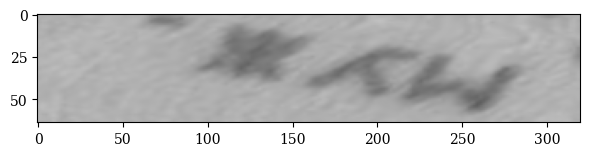

In [44]:
print("Image shape:", x["image"].shape)
print("Seq:", x["seq"], "Seq_len:", x["seq_len"])
print("Text:", x["text"])
plt.imshow(x["image"])
plt.show()

---

Класс `DataLoader` плохо справляется (из коробки) с данными переменного размера в одном батче. Однако, как увидим далее, реализация `ctc_loss` позволяет передавать батч последовательностей в "склеенном" виде, поскольку отдельным параметром передаются длины всех последовательностей в батче.

Таким образом, если в батче были последовательности длин `[8, 9, 9, 9]`, то мы склеим их в одну последовательность длины `35`, а `ctc_loss` под капотом сам "нарежет" ее на части нужной длины.

Для этого вручную реализуем функцию `collate_fn`, чтобы `DataLoader` понял, как формировать батчи.

*Здесь же реализовано преобразование `image` из формата `np.ndarray` в формат `torch.Tensor`.*

In [45]:
def collate_fn(batch):
    """Function for torch.utils.data.Dataloader for batch collecting.
    
    Args:
        - batch: List of dataset __getitem__ return values (dicts).
        
    Returns:
        Dict with same keys but values are either torch.Tensors of batched images or sequences or so.
    """
    images, seqs, seq_lens, texts = [], [], [], []
    for item in batch:
        images.append(torch.from_numpy(item["image"]).permute(2, 0, 1).float())
        seqs.extend(item["seq"])
        seq_lens.append(item["seq_len"])
        texts.append(item["text"])
    images = torch.stack(images)
    seqs = torch.Tensor(seqs).int()
    seq_lens = torch.Tensor(seq_lens).int()
    batch = {"image": images, "seq": seqs, "seq_len": seq_lens, "text": texts}
    return batch

In [46]:
xs = [dataset[i] for i in range(4)]
batch = collate_fn(xs)
print(batch.keys())

dict_keys(['image', 'seq', 'seq_len', 'text'])


In [47]:
print("Image:", batch["image"].size())
print("Seq:", batch["seq"].size())
print("Seq:", batch["seq"])
print("Seq_len:", batch["seq_len"])
print("Text:", batch["text"])

Image: torch.Size([4, 3, 64, 320])
Seq: torch.Size([25])
Seq: tensor([255, 207, 579, 501, 580, 356, 207, 501, 580, 210, 492,  50, 219, 531,
        165, 207, 219,  70, 356,  70, 299, 210, 491, 402,  58],
       dtype=torch.int32)
Seq_len: tensor([6, 5, 5, 9], dtype=torch.int32)
Text: ['Атырау', 'транз', 'ходят', 'ощущений,']


### 3. Построение модели CRNN-like

Начнем с построения `feature_extractor` - cnn.

Я рассматривала несколько вариантов предобученных моделей: `ResNet18`, `ResNet34`, `mobilenet_v2`, `efficientnet_b0`. Я использовала `efficientnet_b0`: отрежем от нее последние два слоя (это `AdaptiveAvgPool2d` и `Linear`), оставив полносверточную часть. После всех сверточных слоев размер входного изображения уменьшается в 32 раза, а значит, входная картинка размером `64x320` превратится в тензор с высотой и шириной `2x10`. Для него мы сделаем пулинг по высоте (смотри параметры `self.pool`), превратив его в тензор размера `1x10`. 

Получим, что длина последовательности для подачи в `RNN` составляет всего лишь 10 (этого может быть мало для хорошей работы `CTC-Loss` с таргетами длины 8 или 9). Используем трюк (в методе `apply_projection`), применив сверточный слой с ядром (1x1) вдоль размерности ширины (а не глубины, как обычно), увеличив длину последовательности с 10 до `output_len`.

In [48]:
# from torchvision.models import mobilenet_v2


# class FeatureExtractor(Module):
    
#     def __init__(self, input_size=(IMAGE_HEIGHT, IMAGE_WIDTH), output_len=OUTPUT_LEN):
#         super(FeatureExtractor, self).__init__()
        
#         h, w = input_size
#         mobilenet = mobilenet_v2(pretrained=True)
#         self.cnn = Sequential(*list(mobilenet.children())[:-1])
        
#         self.pool = AvgPool2d(kernel_size=(h // 32, 1))        
#         self.proj = Conv2d(w // 32, output_len, kernel_size=1)
  
#         self.num_output_features = 1280   

    
#     def apply_projection(self, x):
#         """Use convolution to increase width of a features.
        
#         Args:
#             - x: Tensor of features (shaped B x C x H x W).
            
#         Returns:
#             New tensor of features (shaped B x C x H x W').
#         """
#         x = x.permute(0, 3, 2, 1).contiguous()
#         x = self.proj(x)
#         x = x.permute(0, 2, 3, 1).contiguous()
        
#         return x
   
#     def forward(self, x):
#         # Apply conv layers
#         features = self.cnn(x)
        
        
#         # Pool to make height == 1
#         features = self.pool(features)
        
#         # Apply projection to increase width
#         features = self.apply_projection(features)
        
#         return features

In [57]:
from torchvision.models import efficientnet_b0


class FeatureExtractor(Module):
    
    def __init__(self, input_size=(IMAGE_HEIGHT, IMAGE_WIDTH), output_len=OUTPUT_LEN):
        super(FeatureExtractor, self).__init__()
        
        h, w = input_size
        efficientnet = efficientnet_b0(pretrained=True)
        self.cnn = Sequential(*list(efficientnet.children())[:-2])
        
        self.pool = AvgPool2d(kernel_size=(h // 32, 1))        
        self.proj = Conv2d(w // 32, output_len, kernel_size=1)
  
        self.num_output_features = 1280   

    
    def apply_projection(self, x):
        """Use convolution to increase width of features.
        
        Args:
            - x: Tensor of features (shaped B x C x H x W).
            
        Returns:
            New tensor of features (shaped B x C x H x W').
        """
        x = x.permute(0, 3, 2, 1).contiguous()
        x = self.proj(x)
        x = x.permute(0, 2, 3, 1).contiguous()
        
        return x
   
    def forward(self, x):
        # Apply conv layers
        features = self.cnn(x)
#         print(features.size())
        
        # Pool to make height == 1
        features = self.pool(features)
        
        # Apply projection to increase width
        features = self.apply_projection(features)
        
        return features


In [62]:
feature_extractor = FeatureExtractor()

In [63]:
x = torch.randn(1, 3, IMAGE_HEIGHT, IMAGE_WIDTH)
y = feature_extractor(x)
assert y.size() == (1, 1, 1280, OUTPUT_LEN)

In [64]:
feature_extractor(x).size()

torch.Size([1, 1, 1280, 30])

Итого, `FeaturesExtractor`:
- На вход получает тензор изображения размером `Bx3xHxW`
- На выходе отдает тензор признаков размером `Bx1xFxL`, где 
  - `F` - размерность вектора-токена (определяется числом признаков последнего сверточного слоя `efficientnet_b0`, т.е. 1280), 
  - `L` - "длина последовательности" токенов (`self.output_len`).

---

Теперь напишем класс для рекуррентной части пайплайна.

Будем использовать `GRU` (`bidirectional` или нет - выбор по параметру). Результат предсказаний после `GRU` дополнительно проведем через линейный слой для формирования итоговой матрицы с `logits`. 

  *Про размерность `hidden_state` можно [посмотреть в документации](https://pytorch.org/docs/stable/nn.html?highlight=gru#torch.nn.GRU).*



`GRU` по умолчанию ожидает на вход тензор размера `L x B x F`, где `L` - длина последовательности, `B` - размер батча, `F` - размер одного элемента последовательности. 

Поэкспериментировала с classifier - обычный линейный слой работает также хорошо

In [65]:
import torch.nn as nn

class SequencePredictor(Module):
    
    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout=0.3, bidirectional=True):
        super(SequencePredictor, self).__init__()
        
        self.num_classes = num_classes        
        self.rnn = GRU(input_size=input_size,
                       hidden_size=hidden_size,
                       num_layers=num_layers,
                       dropout=dropout,
                       bidirectional=bidirectional)
        
        fc_in = hidden_size if not bidirectional else 2 * hidden_size
        self.fc = Linear(in_features=fc_in,
                         out_features=num_classes)
        
#         self.classifier = nn.Sequential(
#             nn.Linear(fc_in, fc_in // 2),
#             nn.GELU(),
#             nn.Dropout(0.1),
#             nn.Linear(fc_in // 2, num_classes)
#         )
    
    def _init_hidden(self, batch_size):
        """Initialize new tensor of zeroes for RNN hidden state.
        
        Args:
            - batch_size: Int size of batch
            
        Returns:
            Tensor of zeros shaped (num_layers * num_directions, batch, hidden_size).
        """
        num_directions = 2 if self.rnn.bidirectional else 1
        
        # YOUR CODE HERE
        h = torch.zeros(self.rnn.num_layers * num_directions, batch_size, self.rnn.hidden_size)
        # END OF YOUR CODE
        
        return h
        
    def _reshape_features(self, x):
        """Change dimensions of x to fit RNN expected input.
        
        Args:
            - x: Tensor x shaped (B x (C=1) x H x W).
        
        Returns:
            New tensor shaped (W x B x H).
        """
        
        # YOUR CODE HERE
        x = x.squeeze(1)
        x = x.permute(2, 0, 1)
        # END OF YOUR CODE
        
        return x
    
    def forward(self, x):
        x = self._reshape_features(x)
        
        batch_size = x.size(1)
        h_0 = self._init_hidden(batch_size)
        h_0 = h_0.to(x.device)
        x, h = self.rnn(x, h_0)
        
        x = self.fc(x)
#         x = self.classifier(x)
        return x

In [66]:
sequence_predictor = SequencePredictor(input_size=1280, 
                                       hidden_size=128, 
                                       num_layers=2, 
                                       num_classes=len(abc) + 1)

In [67]:
x = torch.randn(1, 1, 1280, OUTPUT_LEN)
assert sequence_predictor._reshape_features(x).size() == (OUTPUT_LEN, 1, 1280)

In [68]:
y = sequence_predictor(x)
assert y.size() == (OUTPUT_LEN, 1, len(abc)+1)

In [69]:
y.size()

torch.Size([30, 1, 605])

---

Теперь соберем две части в один класс CRNN.

In [70]:
class CRNN(Module):
    
    def __init__(self, alphabet=abc,
                 cnn_input_size=(IMAGE_HEIGHT, IMAGE_WIDTH), cnn_output_len=OUTPUT_LEN,
                 rnn_hidden_size=128, rnn_num_layers=2, rnn_dropout=0.3, rnn_bidirectional=True):
        super(CRNN, self).__init__()
        self.alphabet = alphabet
        self.features_extractor = FeatureExtractor(input_size=cnn_input_size, 
                                                   output_len=cnn_output_len)
        self.sequence_predictor = SequencePredictor(input_size=self.features_extractor.num_output_features,
                                                    hidden_size=rnn_hidden_size, 
                                                    num_layers=rnn_num_layers,
                                                    num_classes=len(alphabet)+1, 
                                                    dropout=rnn_dropout,
                                                    bidirectional=rnn_bidirectional)
    
    def forward(self, x):
        features = self.features_extractor(x)
        sequence = self.sequence_predictor(features)
        return sequence

Кроме того, добавим также функции для декодирования результата `sequence_predictor` в читаемый вид.

In [71]:
def pred_to_string(pred, abc):
    seq = []
    for i in range(len(pred)):
        label = np.argmax(pred[i])
        seq.append(label - 1)
    out = []
    for i in range(len(seq)):
        if len(out) == 0:
            if seq[i] != -1:
                out.append(seq[i])
        else:
            if seq[i] != -1 and seq[i] != seq[i - 1]:
                out.append(seq[i])
    out = ''.join([abc[c] for c in out])
    return out

def decode(pred, abc):
    pred = pred.permute(1, 0, 2).cpu().data.numpy()
    outputs = []
    for i in range(len(pred)):
        outputs.append(pred_to_string(pred[i], abc))
    return outputs

Проверим, как все работает на случайном тензоре:

In [72]:
crnn = CRNN()

x = torch.randn(1, 3, IMAGE_HEIGHT, IMAGE_WIDTH)
y = crnn(x)
assert y.size() == (OUTPUT_LEN, 1, len(abc)+1)

decode(y, abc)

['観ἰF산維)…[（楊奶ع蘇Ъ×ο▪i▪пгх▪楊×Ｔο']

### 4. CTC-Loss

Для обучения модели предсказания последовательностей будем использовать `CTC-Loss`. Класс этой функции потерь уже реализован в `PyTorch`, поэтому нам нужно только понять, как правильно подать в него предсказания и `ground-truth`-метки. Для этого обратимся к [документации](https://pytorch.org/docs/stable/nn.functional.html?highlight=ctc#torch.nn.functional.ctc_loss):

![ctc-01](resources/ctc_01.png) 

![ctc-02](resources/ctc_02.png)

На что следует обратить внимание:
* Функция ожидает на вход не только пару предсказанных и верных последовательностей, но и информацию о длинах этих последовательностей.
* Перед тем, как подавать предсказания в лосс, необходимо применить к ним активацию `softmax` и затем взять логарифм.

### 5. Обучение и результаты

Инициализируем модель (пока все параметры можно оставить по умолчанию - они подойдут для начала):

In [95]:
crnn = CRNN()

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
crnn.to(device);

Зададим гиперпараметры обучения:

In [115]:
num_epochs = 30
batch_size = 64
num_workers = 4

In [116]:
from torch.optim.lr_scheduler import ExponentialLR

optimizer = torch.optim.Adam(crnn.parameters(), lr=3e-4, amsgrad=True, weight_decay=1e-4)
scheduler = ExponentialLR(optimizer, gamma=0.9, verbose=True)

Adjusting learning rate of group 0 to 3.0000e-04.


Поделим данные на обучающую и валидационную выборки:

In [117]:
config[:5]

[{'file': '/kaggle/input/vk-made-ocr/train/train/192549.jpg',
  'text': '9573882'},
 {'file': '/kaggle/input/vk-made-ocr/train/train/197213.jpg',
  'text': 'Шалкар'},
 {'file': '/kaggle/input/vk-made-ocr/train/train/87077.jpg',
  'text': 'ESPRESS'},
 {'file': '/kaggle/input/vk-made-ocr/train/train/253509.jpg',
  'text': 'скандала'},
 {'file': '/kaggle/input/vk-made-ocr/train/train/147787.jpg',
  'text': 'запрета'}]

In [118]:
len(config)

274531

In [119]:
274630/5000

54.926

In [121]:
np.random.shuffle(config)
train_size = int(len(config) * 0.99)
config_train = config[:train_size]
config_val = config[train_size:]

# train_dataset = RecognitionDataset(config_train, transforms=Resize())
# val_dataset = RecognitionDataset(config_val, transforms=Resize())

# np.random.shuffle(config)
# config_train = config[:4000]
# config_val = config[4000:4500]

train_dataset = RecognitionDataset(config_train, transforms=data_transforms["train"])
val_dataset = RecognitionDataset(config_val, transforms=data_transforms["validation"])

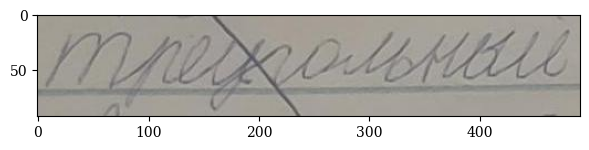

In [122]:
plt.imshow(Image.open(TRAIN_DATA_PATH + "223471.jpg"))

Создадим объекты типа `DataLoader` для формирования батчей обучения. Обратите внимание на следующие вещи:
* Мы передаем функцию `collate_fn` как параметр конструктора;
* Значения параметров `shuffle` и `drop_last` отличаются для случаев обучения и валидации - зачем так сделано?

In [123]:
train_dataloader = DataLoader(train_dataset, 
                              batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True, 
                              drop_last=True, collate_fn=collate_fn)
val_dataloader = DataLoader(val_dataset, 
                            batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True, 
                            drop_last=False, collate_fn=collate_fn)

In [124]:
len(train_dataloader) * batch_size, len(val_dataloader) * batch_size

(271744, 2752)

Запустим обучение (при параметрах по умолчанию эпоха занимает ~22 секунды на GPU):

In [125]:
import tqdm

crnn.train()
for epoch in range(num_epochs):
    epoch_losses = []

    for b in tqdm.tqdm(train_dataloader, total=len(train_dataloader)):
        images = b["image"].to(device)
        seqs_gt = b["seq"]
        seq_lens_gt = b["seq_len"]

        seqs_pred = crnn(images).cpu()
        log_probs = log_softmax(seqs_pred, dim=2)
        seq_lens_pred = torch.Tensor([seqs_pred.size(0)] * seqs_pred.size(1)).int()

        loss = ctc_loss(log_probs=log_probs,  # (T, N, C)
                        targets=seqs_gt,  # N, S or sum(target_lengths)
                        input_lengths=seq_lens_pred,  # N
                        target_lengths=seq_lens_gt,  # N
                        zero_infinity=True)

        optimizer.zero_grad()
        loss.backward()
        
        # clip here
        torch.nn.utils.clip_grad_norm_(crnn.parameters(), 1.0) # or some other value

        optimizer.step()

        epoch_losses.append(loss.item())
    
    scheduler.step()  # Обновление скорости обучения

    print(f"Epoch {epoch+1}/{num_epochs} - Training Loss: {np.mean(epoch_losses):.4f}")
    print('-' * 10)

print('Training complete')

  1%|          | 47/4246 [00:09<14:41,  4.76it/s] 


KeyboardInterrupt: 

In [ ]:
test_dataloader = val_dataloader

crnn.eval()
val_losses = []
for b in tqdm.tqdm(test_dataloader, total=len(test_dataloader)):
    images = b["image"].to(device)
    seqs_gt = b["seq"]
    seq_lens_gt = b["seq_len"]

    with torch.no_grad():
        seqs_pred = crnn(images).cpu()
    log_probs = log_softmax(seqs_pred, dim=2)
    seq_lens_pred = torch.Tensor([seqs_pred.size(0)] * seqs_pred.size(1)).int()

    loss = ctc_loss(log_probs=log_probs,  # (T, N, C)
                    targets=seqs_gt,  # N, S or sum(target_lengths)
                    input_lengths=seq_lens_pred,  # N
                    target_lengths=seq_lens_gt,  # N
                    zero_infinity=True)  

    val_losses.append(loss.item())

print(f'Validation Loss: {np.mean(val_losses):.4f}')

Теперь возьмем несколько картинок из валидации и посмотрим на предсказанные для них распределения.

In [108]:
y_ticks = ["-"] + [x for x in abc]

images = b["image"]
seqs_gt = b["seq"]
seq_lens_gt = b["seq_len"]
texts = b["text"]

preds = crnn(images.to(device)).cpu().detach()
texts_pred = decode(preds, crnn.alphabet)

### Submission

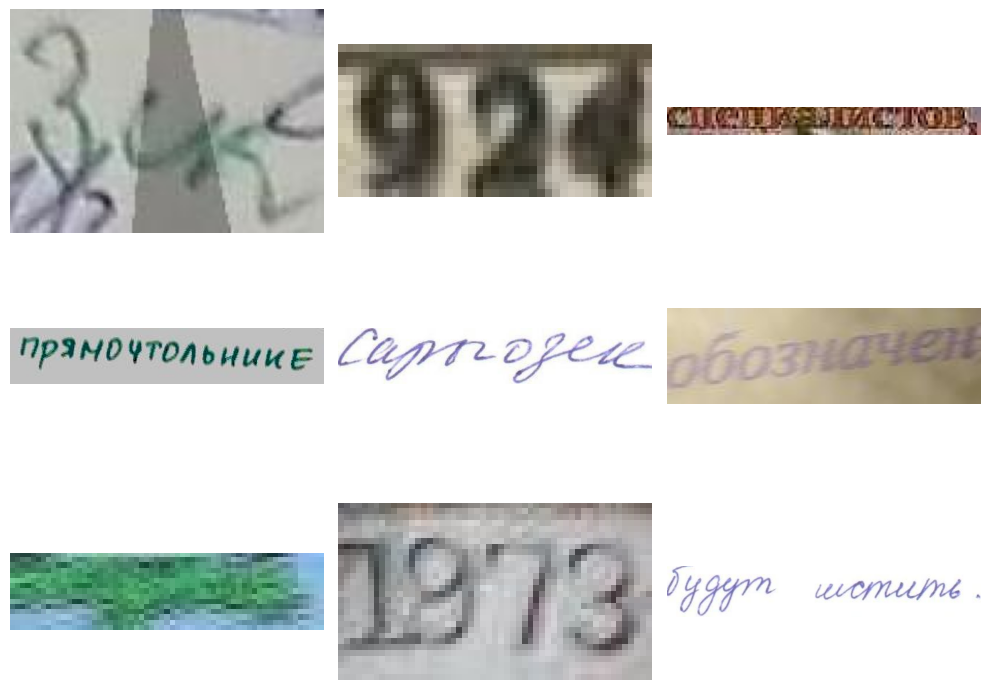

In [111]:
fig, axs = plt.subplots(3, 3, figsize=(10, 8))

for i, ax in enumerate(axs.flatten()):
    img_name = ["49917.jpg", "10.jpg", "100.jpg", "1000.jpg", "10000.jpg", "40874.jpg", "10017.jpg", "10049.jpg", "10019.jpg"] 
    img = Image.open(TEST_DATA_PATH + img_name[i])
    
    # отобразить изображение
    ax.imshow(img)
    ax.axis('off')

plt.tight_layout()
plt.show()

In [112]:
def predict(path_image, model):
#     image = cv2.imread(path_image).astype(np.float32) / 255.
    image, rotated = load_image(path_image)
    image = data_transforms["validation"](image=image)['image']
    image_tensor = torch.from_numpy(image).permute(2, 0, 1).float()
    image_tensor = image_tensor.unsqueeze(0)  
    preds = model(image_tensor.to(device)).cpu().detach()
    texts_pred = decode(preds, crnn.alphabet)

    return texts_pred

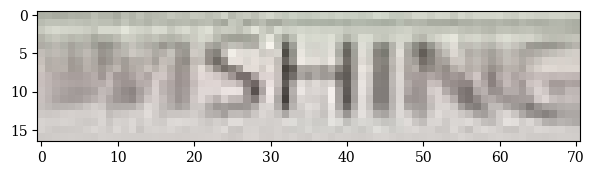

In [113]:
plt.imshow(Image.open(TEST_DATA_PATH + "10059.jpg"))

In [114]:
predict(TEST_DATA_PATH + "10059.jpg", crnn)

['1']

In [76]:
import os

submission = {}

# Получение списка файлов в директории
files = os.listdir(TEST_DATA_PATH)

# Проход циклом по файлам с прогресс-баром
for file in tqdm.tqdm(files, total=len(files)):
    # Проверка, что файл является изображением (пример: проверка расширения файла)
    if file.endswith(".jpg") or file.endswith(".png"):
        # Полный путь к файлу
        file_path = os.path.join(TEST_DATA_PATH, file)
        
        submission[file] = predict(file_path, crnn)[0]

100%|██████████| 52999/52999 [13:03<00:00, 67.63it/s]


In [77]:
df = pd.DataFrame(submission.items(), columns=['Id', 'Predicted'])
df.head()

,Id,Predicted
0,31973.jpg,т
1,30778.jpg,В
2,19812.jpg,AIO CESSONS
3,22735.jpg,
4,38246.jpg,Епланса


In [78]:
df.to_csv('/kaggle/working/submission.csv', index=False)

In [139]:
torch.save(crnn.state_dict(), 'crnn_mobilenet.pth')

### CER

1. Что можно сделать: 
- ctc loss + beam search, 
- mobile net, 
- менее сложный sequence predictor, 
- gru -> lstm

In [249]:
import Levenshtein

def compute_cer(img_name, train_labels):
    target = train_labels[train_labels["Id"]==img_name]["Expected"].values[0].lower()
    prediction = predict(TRAIN_DATA_PATH + img_name, crnn)[0].lower()
    cer = Levenshtein.distance(target, prediction) / len(target)
    return cer

['None']


['тредфольный']

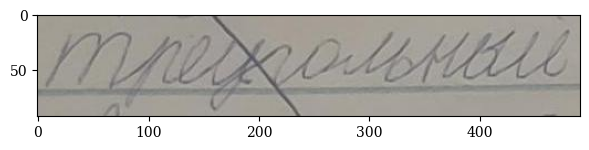

In [250]:
img_name = "223471.jpg"
plt.imshow(Image.open(TRAIN_DATA_PATH + img_name))
print(train_labels[train_labels["Id"]==img_name]["Expected"].values)
predict(TRAIN_DATA_PATH + img_name, crnn)

In [251]:
compute_cer(img_name, train_labels)

2.75

In [252]:
train_labels[train_labels["Expected"]=='None']

,Id,Expected,Expected_Length,file,text
5035,5036.jpg,None,4,/kaggle/input/vk-ocr/train/train/5036.jpg,None
11279,11280.jpg,None,4,/kaggle/input/vk-ocr/train/train/11280.jpg,None
12282,12283.jpg,None,4,/kaggle/input/vk-ocr/train/train/12283.jpg,None
15627,15628.jpg,None,4,/kaggle/input/vk-ocr/train/train/15628.jpg,None
18416,18417.jpg,None,4,/kaggle/input/vk-ocr/train/train/18417.jpg,None
...,...,...,...,...,...
246426,246427.jpg,None,4,/kaggle/input/vk-ocr/train/train/246427.jpg,None
248431,248432.jpg,None,4,/kaggle/input/vk-ocr/train/train/248432.jpg,None
263881,263882.jpg,None,4,/kaggle/input/vk-ocr/train/train/263882.jpg,None
264668,264669.jpg,None,4,/kaggle/input/vk-ocr/train/train/264669.jpg,None


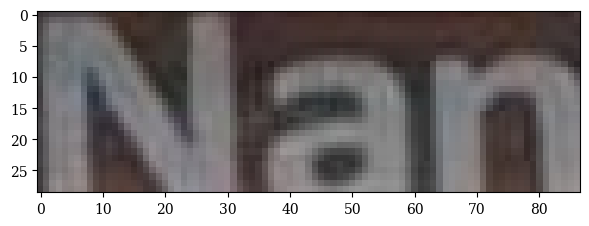

In [253]:
plt.imshow(Image.open(TRAIN_DATA_PATH + "244733.jpg"))

In [258]:
dff=train_labels.sample(150_000)
dff

,Id,Expected,Expected_Length,file,text
152410,152411.jpg,Казахстан,9,/kaggle/input/vk-ocr/train/train/152411.jpg,Казахстан
265215,265216.jpg,"""йЦрАж6З?4",10,/kaggle/input/vk-ocr/train/train/265216.jpg,"""йЦрАж6З?4"
151115,151116.jpg,работы,6,/kaggle/input/vk-ocr/train/train/151116.jpg,работы
213526,213527.jpg,XIYUTEA,7,/kaggle/input/vk-ocr/train/train/213527.jpg,XIYUTEA
159469,159470.jpg,румынию.,8,/kaggle/input/vk-ocr/train/train/159470.jpg,румынию.
...,...,...,...,...,...
138468,138469.jpg,"держатель,",10,/kaggle/input/vk-ocr/train/train/138469.jpg,"держатель,"
8733,8734.jpg,15977024188,11,/kaggle/input/vk-ocr/train/train/8734.jpg,15977024188
79704,79705.jpg,APAR,4,/kaggle/input/vk-ocr/train/train/79705.jpg,APAR
68545,68546.jpg,эфиопии,7,/kaggle/input/vk-ocr/train/train/68546.jpg,эфиопии


In [ ]:
import tqdm
from IPython.display import clear_output

img_names_with_high_cer = []

with tqdm.tqdm(total=len(dff), desc="Computing CER", bar_format='{desc}: {percentage:3.0f}%|{bar}| {n_fmt}/{total_fmt}') as pbar:
    for img_name in dff["Id"]:
        cer = compute_cer(img_name, dff)
        if cer > 2.0:
            img_names_with_high_cer.append(img_name)
        
        clear_output(wait=True)  # Очищаем вывод ячейки
        pbar.update(1)


Computing CER:   1%|▏         | 2156/150000

In [257]:
img_names_with_high_cer

[]

['R']


['®']

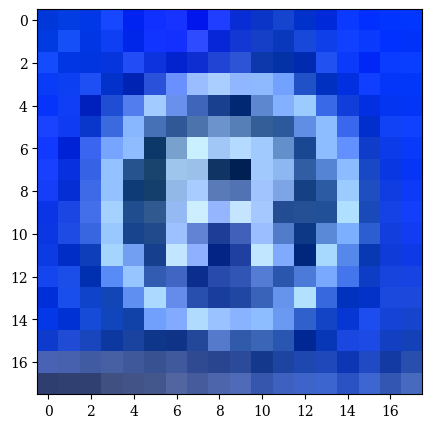

In [232]:
img_name = "71112.jpg"
plt.imshow(Image.open(TRAIN_DATA_PATH + img_name))
print(train_labels[train_labels["Id"]==img_name]["Expected"].values)
predict(TRAIN_DATA_PATH + img_name, crnn)

In [197]:
abc.find('®')

216